In [1]:
# Cell 1: imports + loaders
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")

base = Path("SVM")

def load_X(name):
    df = pd.read_csv(base / name)
    if df.columns[0].startswith("Unnamed"):
        df = df.drop(columns=df.columns[0])
    return df

def load_y(name):
    df = pd.read_csv(base / name)
    if df.columns[0].startswith("Unnamed"):
        df = df.drop(columns=df.columns[0])
    return df.iloc[:, 0].astype(str)

tcga = {
    "X_train": load_X("X_train.csv"),
    "X_test": load_X("X_test.csv"),
    "y_train": load_y("Y_train.csv"),
    "y_test": load_y("Y_test.csv"),
}

norway = {
    "X_train": load_X("X_train_Norway.csv"),
    "X_test": load_X("X_test_Norway.csv"),
    "y_train": load_y("Y_train_Norway.csv"),
    "y_test": load_y("Y_test_Norway.csv"),
}


,count,ratio
Label,,
LumA,230,0.464
LumB,102,0.206
Normal,70,0.141
Basal,70,0.141
Her2,24,0.048


,count,ratio
Label,,
LumA,58,0.468
LumB,25,0.202
Basal,17,0.137
Normal,17,0.137
Her2,7,0.056


,count,ratio
Label,,
LumA,92,0.440
LumB,50,0.239
Her2,30,0.144
Basal,27,0.129
Normal,10,0.048


,count,ratio
Label,,
LumA,23,0.442
LumB,12,0.231
Her2,7,0.135
Basal,7,0.135
Normal,3,0.058


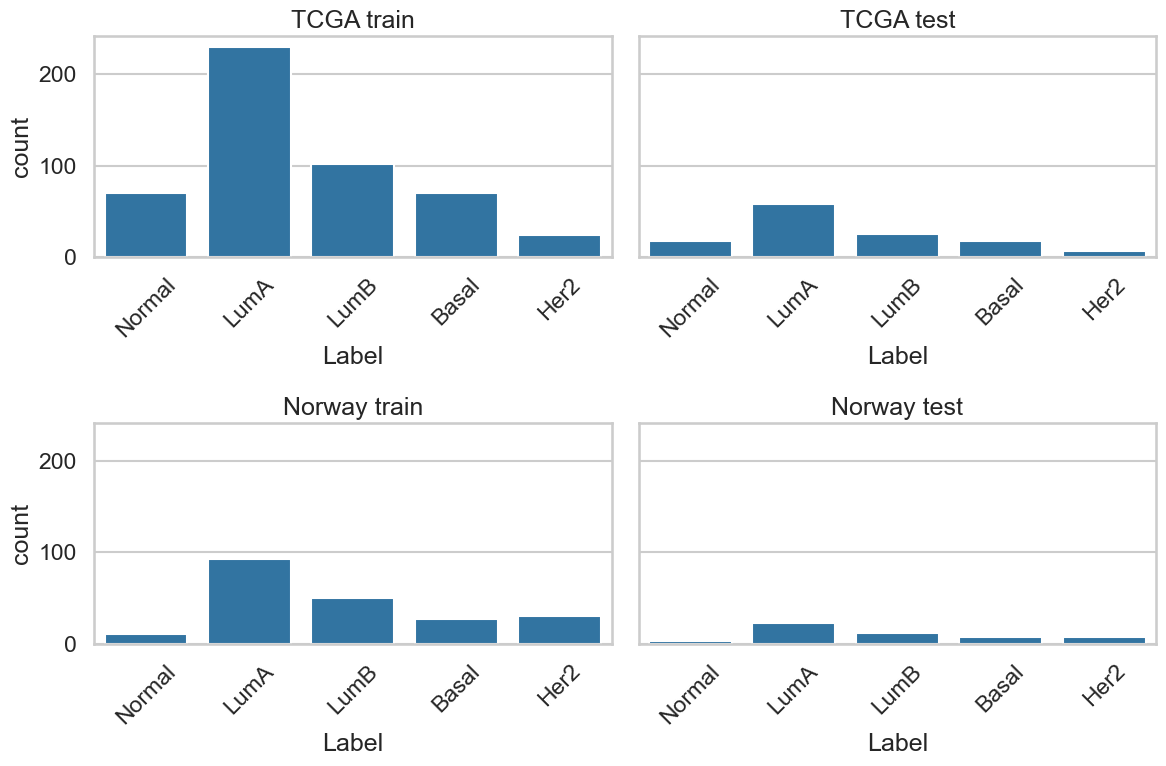

In [3]:
# Cell 2: class balance (train/test)
def class_balance(y):
    counts = y.value_counts()
    ratios = (counts / counts.sum()).round(3)
    return pd.DataFrame({"count": counts, "ratio": ratios})

display(class_balance(tcga["y_train"]), class_balance(tcga["y_test"]))
display(class_balance(norway["y_train"]), class_balance(norway["y_test"]))

order = pd.Index(pd.concat([tcga["y_train"], norway["y_train"]]).unique()).tolist()

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
sns.countplot(x=tcga["y_train"], order=order, ax=axes[0, 0])
axes[0, 0].set_title("TCGA train")
sns.countplot(x=tcga["y_test"], order=order, ax=axes[0, 1])
axes[0, 1].set_title("TCGA test")

sns.countplot(x=norway["y_train"], order=order, ax=axes[1, 0])
axes[1, 0].set_title("Norway train")
sns.countplot(x=norway["y_test"], order=order, ax=axes[1, 1])
axes[1, 1].set_title("Norway test")

for ax in axes.ravel():
    ax.tick_params(axis="x", rotation=45)
plt.tight_layout()


mean    0.323127
std     0.296094
min     0.006500
max     0.991800
p1      0.017300
p5      0.026250
p25     0.056698
p50     0.213847
p75     0.551600
p95     0.892100
p99     0.943400
dtype: float64

mean    0.330412
std     0.278346
min     0.021511
max     0.973787
p1      0.050843
p5      0.059581
p25     0.082828
p50     0.199048
p75     0.576643
p95     0.833637
p99     0.887024
dtype: float64

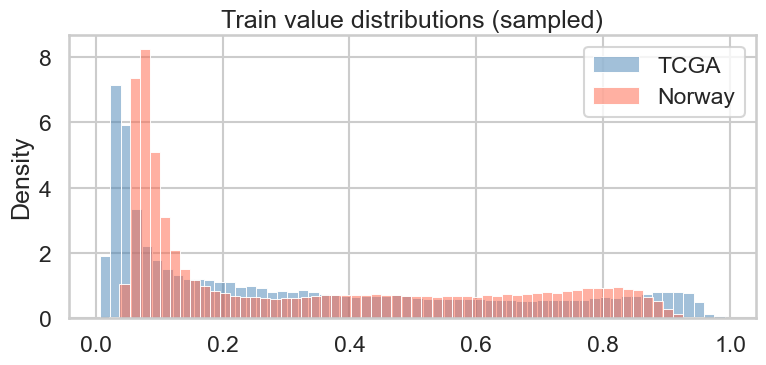

In [4]:
# Cell 3: value distribution summary + histograms
def sample_values(X, n=200_000, seed=0):
    rng = np.random.default_rng(seed)
    flat = X.to_numpy().ravel()
    if flat.size <= n:
        return flat
    idx = rng.integers(0, flat.size, size=n)
    return flat[idx]

def value_summary(values):
    q = np.percentile(values, [1, 5, 25, 50, 75, 95, 99])
    return pd.Series({
        "mean": values.mean(),
        "std": values.std(ddof=0),
        "min": values.min(),
        "max": values.max(),
        "p1": q[0], "p5": q[1], "p25": q[2], "p50": q[3],
        "p75": q[4], "p95": q[5], "p99": q[6],
    })

vals_tcga = sample_values(tcga["X_train"])
vals_nor = sample_values(norway["X_train"])

display(value_summary(vals_tcga), value_summary(vals_nor))

fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(vals_tcga, bins=60, color="steelblue", alpha=0.5, stat="density", ax=ax, label="TCGA")
sns.histplot(vals_nor, bins=60, color="tomato", alpha=0.5, stat="density", ax=ax, label="Norway")
ax.set_title("Train value distributions (sampled)")
ax.legend()
plt.tight_layout()


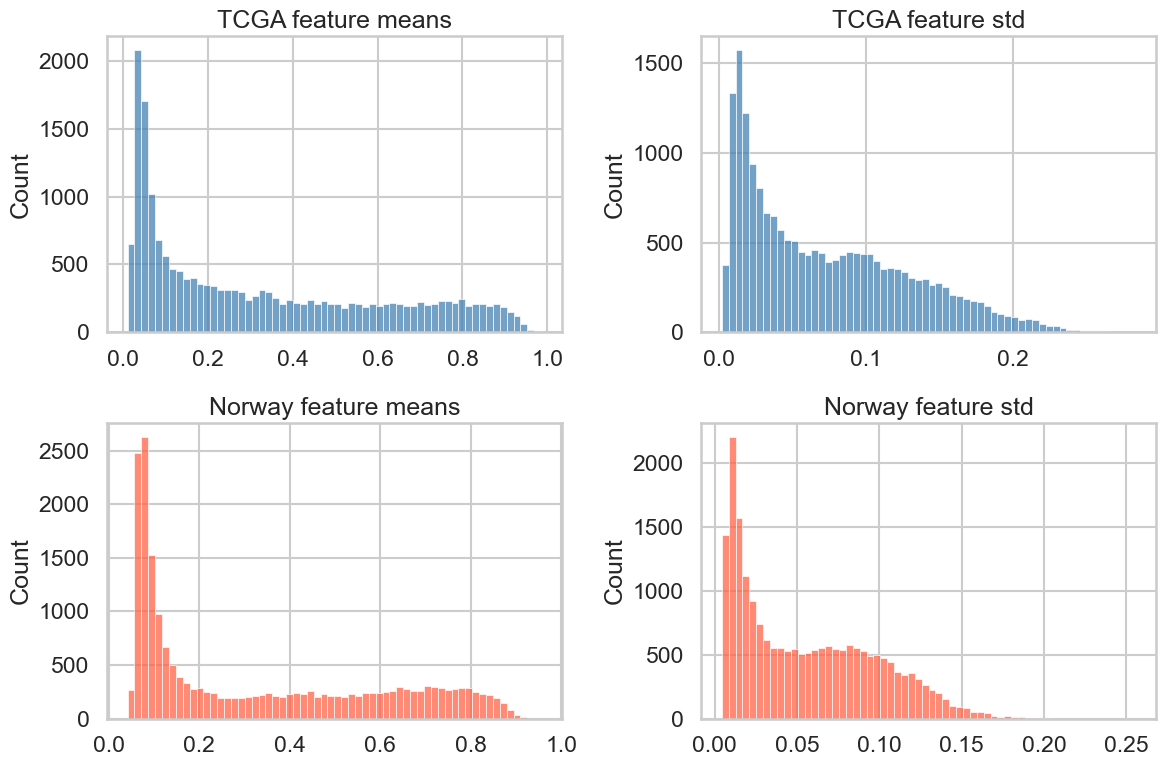

In [5]:
# Cell 4: per-feature mean/std distributions
def feature_stats(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0, ddof=0)
    return mean, std

mean_tcga, std_tcga = feature_stats(tcga["X_train"])
mean_nor, std_nor = feature_stats(norway["X_train"])

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(mean_tcga, bins=60, color="steelblue", ax=axes[0, 0])
axes[0, 0].set_title("TCGA feature means")
sns.histplot(std_tcga, bins=60, color="steelblue", ax=axes[0, 1])
axes[0, 1].set_title("TCGA feature std")

sns.histplot(mean_nor, bins=60, color="tomato", ax=axes[1, 0])
axes[1, 0].set_title("Norway feature means")
sns.histplot(std_nor, bins=60, color="tomato", ax=axes[1, 1])
axes[1, 1].set_title("Norway feature std")

plt.tight_layout()


median         7.296172
p75           18.461702
p90           35.914774
p95           50.666365
frac_gt_10     0.420086
dtype: float64

median         2.772575
p75            5.088479
p90            9.018207
p95           12.762296
frac_gt_10     0.081774
dtype: float64

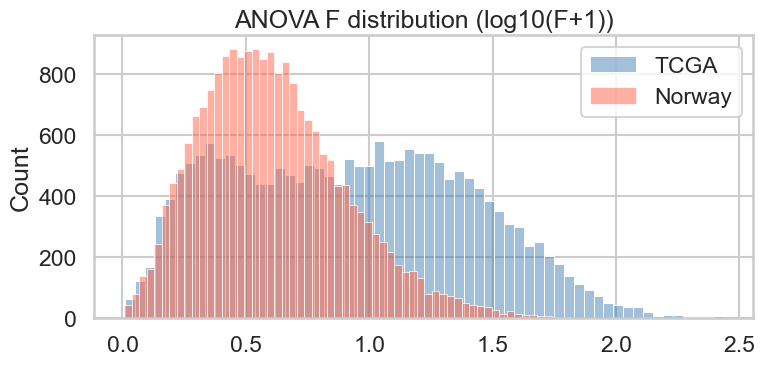

In [6]:
# Cell 5: ANOVA F distribution (class separability)
def anova_fallback(X, y):
    Xv = X.to_numpy()
    yv = pd.Categorical(y).codes
    classes = np.unique(yv)
    overall = Xv.mean(axis=0)
    ssb = np.zeros(Xv.shape[1], dtype=np.float64)
    ssw = np.zeros(Xv.shape[1], dtype=np.float64)

    for c in classes:
        Xc = Xv[yv == c]
        n = Xc.shape[0]
        if n == 0:
            continue
        mean_c = Xc.mean(axis=0)
        var_c = Xc.var(axis=0, ddof=0)
        ssb += n * (mean_c - overall) ** 2
        ssw += n * var_c

    dfb = len(classes) - 1
    dfw = Xv.shape[0] - len(classes)
    f = (ssb / dfb) / (ssw / dfw)
    f[~np.isfinite(f)] = np.nan
    return f

try:
    from sklearn.feature_selection import f_classif
    def anova_f(X, y):
        f, _ = f_classif(X, y)
        return f
except Exception:
    anova_f = anova_fallback

def f_summary(f):
    f = f[np.isfinite(f)]
    return pd.Series({
        "median": np.median(f),
        "p75": np.percentile(f, 75),
        "p90": np.percentile(f, 90),
        "p95": np.percentile(f, 95),
        "frac_gt_10": (f > 10).mean(),
    })

f_tcga = anova_f(tcga["X_train"], tcga["y_train"])
f_nor = anova_f(norway["X_train"], norway["y_train"])

display(f_summary(f_tcga), f_summary(f_nor))

fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(np.log10(f_tcga + 1), bins=60, color="steelblue", alpha=0.5, ax=ax, label="TCGA")
sns.histplot(np.log10(f_nor + 1), bins=60, color="tomato", alpha=0.5, ax=ax, label="Norway")
ax.set_title("ANOVA F distribution (log10(F+1))")
ax.legend()
plt.tight_layout()


Mean diff quantiles:
0.50    0.045222
0.90    0.163741
0.99    0.406106
dtype: float64
Std ratio quantiles (TCGA / Norway):
0.1    0.681870
0.5    1.349238
0.9    2.471272
dtype: float64


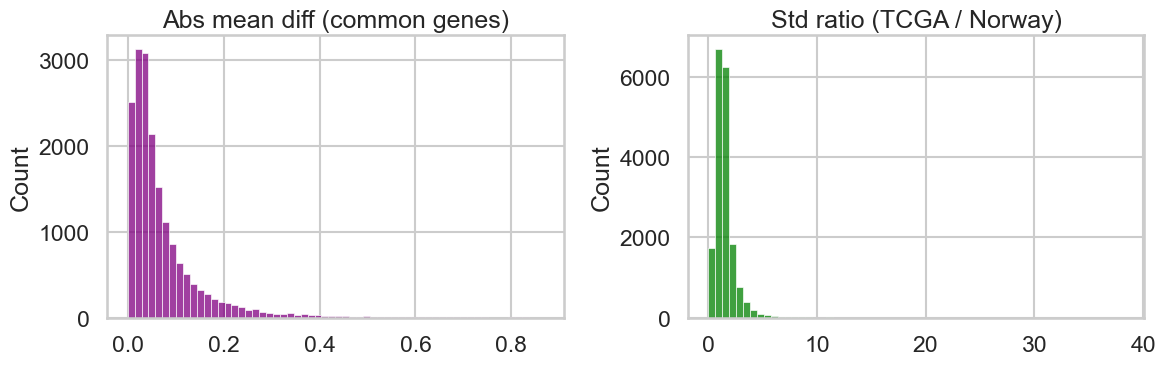

In [7]:
# Cell 6: cross-dataset feature shift (common genes)
common = tcga["X_train"].columns.intersection(norway["X_train"].columns)
tcga_c = tcga["X_train"][common]
nor_c = norway["X_train"][common]

mean_diff = (tcga_c.mean() - nor_c.mean()).abs()
std_ratio = tcga_c.std(ddof=0) / nor_c.std(ddof=0)
std_ratio = std_ratio.replace([np.inf, -np.inf], np.nan).dropna()

print("Mean diff quantiles:")
print(mean_diff.quantile([0.5, 0.9, 0.99]))
print("Std ratio quantiles (TCGA / Norway):")
print(std_ratio.quantile([0.1, 0.5, 0.9]))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(mean_diff, bins=60, color="purple", ax=axes[0])
axes[0].set_title("Abs mean diff (common genes)")
sns.histplot(std_ratio, bins=60, color="green", ax=axes[1])
axes[1].set_title("Std ratio (TCGA / Norway)")
plt.tight_layout()
